# Мастерская 1. Предсказание риска сердечных приступов

В этом проекте предполагается работа с датасетом из открытого источника. Вам потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. В начале проекта вам будет доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также вам будет доступен скрипт, с помощью которого будет измеряться финальная метрика вашей модели.

**Цель исследования**

Цель данного исследования — построить модель машинного обучения для предсказания риска сердечных приступов на основе имеющегося датасета, а также подготовить сохранённый файл модели для последующей интеграции в приложение `FastAPI`. В рамках исследования будет проведена предобработка данных, их анализ, а также выявлены важные признаки, на которых будет обучена модель.

**Ход исследования**

1. **Загрузка и предварительный анализ данных**
    - Загрузка данных тренировочной и тестовой выборок в датафреймы
    - Проверка на соответствие по структуре
2. **Предобработка данных**
    - Проверка на пропуски
    - Приведение названий к стилю `snake_case`
    - Проверка на наличие явных и неявных дубликатов
    - Написание собственных трансформеров для использования в пайплайне, с целью воспроизводимости результатов в приложении `FastAPI`.
3. **Исследовательский анализ данных**
    - Выведение основных статистик
    - Построение графиков
    - Построение матриц корреляций
4. **Подготовка данных к обучению**
    - Разбиение датафрейма с тренировочными данными на тренировочную и валидационную выборки
    - Написание пайплайна
5. **Обучение модели**
    - Поиск лучшей модели с помощью `RandomizedSearchCV`
    - Сохранение лучшей модели для дальнейшего использования в приложении `FastAPI`


## Шаг 0.1 Установка и импорт нужных библиотек

In [1]:
# Установка нужных библиотек
%pip install -q catboost missingno shap dill

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт основных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Импорт специализированных сторонних библиотек
import dill
import missingno as msno
from pathlib import Path
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

# Импорт библиотек машиннного обучения
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    fbeta_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

## Шаг 0.2 Глобальные переменные и функции, использующиеся в проекте

### Глобальные переменные

In [3]:
RANDOM_STATE = 42

### Функции из шага 1. "Загрузка и подготовка данных"

In [4]:
def load_data(names: list) -> list[pd.DataFrame]:
    """
    Создаёт словарь из датафреймов из переданных названий csv файлов.
    Ключи словаря - имена файлов, значения - датафреймы
    """
    def load_csv(filename):
        """
        Возвращает датафрейм из переданного csv файла
        """
        # Задаём путь относительно корня
        data_dir = Path('../data/raw')
        # Получаем путь к файлу
        file_path = data_dir / f'{filename}.csv'
        return pd.read_csv(file_path, index_col=0)

            
    # Создаём словарь с датафреймами
    dfs_dict = {name: load_csv(name) for name in names}

    # Возвращаем список с датафреймами
    return dfs_dict


def show_info(df: pd.DataFrame) -> None:
    """
    Выводит первичную информацию датафреймов.
    """
    # Выводим на экран первые и последние 5 строк датафрейма
    display(pd.concat([df.head(), df.tail()]))
    df.info()

In [5]:
def check_duplicates(df: pd.DataFrame, name: str) -> None:
    """
    Выводит на экран количество явных дубликатов и строки с ними, если они есть,
    или информацию о том, что явных дубликатов нет
    """
    # Считаем количество явных дубликатов
    dups = df.duplicated().sum()
    # Если количество дубликатов больше 0
    if dups > 0:
        # Выводим количество дубликатов в датафрейме
        print(f'Количество явных дубликатов в датафрейме {name} = {dups}')
        # Выводим на экран дубликаты и их количество
        display(df.value_counts().loc[lambda x: x > 1])
    else:
        print(f'В датафрейме из таблицы {name}.csv нет явных дубликатов.')

In [6]:
def check_dups_in_col(df: pd.DataFrame, name:str, col: str) -> None:
    """
    Проверяет наличие неявных дубликатов в переданном столбце,
    при наличии дубликатов выводит строки с повторяющимися значениями.
    """
    dups_count = df[col].duplicated().sum()
    if dups_count > 0:
        print(f'Количество неявных дубликатов в датафрейме {name} в столбце {col}:', dups_count)
        display(df[df[col].duplicated(keep=False)].sort_values(by='id'))
    else:
        print(f'В датафрейме {name} в столбце {col} отсутствуют неявные дубликаты.')

### Функции из шага 2. Предобработка данных

### Функции из шага 4. Подготовка данных

In [7]:
class SimpleImputerStep(BaseEstimator, TransformerMixin):
    """
    Заполняет пропуски, используя переданную стратегию.
    """
    def __init__(self, columns, strategy='median'):
        self.columns = columns
        self.strategy = strategy

    def fit(self, X, y=None):
        self.imputer = {
            col: SimpleImputer(strategy=self.strategy).fit(X[[col]])
            for col in self.columns
        }
        self.is_fitted_ = True
        return self

    def transform(self, X):
        X = X.copy()
        # Заполняем пропуски в переданных столбцах
        for col, imp in self.imputer.items():
            X[col] = imp.transform(X[[col]])
        return X


class ColumnNameCleaner(BaseEstimator, TransformerMixin):
    """
    Приводит названия столбцов к стилю snake_case.
    """
    def __init__(self, return_mapping=False, validate=False):
        self.return_mapping = return_mapping
        self.validate = validate
        self.mappings_ = None
        self.expected_columns_ = None

    @staticmethod
    def _clean_names(df: pd.DataFrame, return_mapping=False):
        import pandas as pd
        
        old_names = pd.Series(df.columns, name="Старые названия")
        df = df.copy()
        df.columns = (
            df.columns
            .str.strip()
            .str.lower()
            .str.replace(r"\s+\(.+?\)", "", regex=True)
            .str.replace(r"\s+", "_", regex=True)
        )

        if return_mapping:
            new_names = pd.Series(df.columns, name="Новые названия")
            mapping_df = pd.concat([old_names, new_names], axis=1)
            return df, mapping_df
        
        return df

    def fit(self, X, y=None):
        if self.return_mapping:
            # Приводим названия, и сохраняем старые/новые названия
            cleaned_X, mappings = self._clean_names(X, return_mapping=True)
            self.mappings_ = mappings
        else:
            cleaned_X = self._clean_names(X) # Только приводим названия

        # Сохраняем ожидаемые колонки для проверки
        self.expected_columns_ = set(cleaned_X.columns)
        self.is_fitted_ = True

        return self

    def transform(self, X):
        X = self._clean_names(X)
        # Если стоит флаг проверки
        if self.validate:
            # Проводим проверку на соответствие столбцов
            current_columns = set(X.columns)
            if current_columns != self.expected_columns_:
                missing = self.expected_columns_ - current_columns
                extra = current_columns - self.expected_columns_
                raise ValueError(
                    f"Несоответствие столбцов после очистки:\n"
                    f"Отсутствуют: {missing}\nЛишние: {extra}"
                )
        return X
    

class GenderCleaner(BaseEstimator, TransformerMixin):
    """
    Преобразовывает значения в столбце 'gender'.
    """
    def __init__(self, column='gender'):
        self.column = column
        self.mapping_ = {'Male': 1.0, 'Female': 0.0, '1.0': 1.0, '0.0': 0.0, '1': 1.0, '0': 0.0}

    def fit(self, X, y=None):
        if self.column not in X.columns:
            raise ValueError(f'Столбец "{self.column}" отсутствует в данных.')
        # Проверка на допустимость значений
        unique_values = set(X[self.column].astype(str).unique()) - set(self.mapping_.keys())
        if unique_values:
            raise ValueError(f'Недопустимые значения в столбце "{self.column}": {unique_values}')
        
        self.is_fitted_ = True

        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if self.column not in X.columns:
            raise ValueError(f'Столбец "{self.column}" отсутствует в данных.')
        
        X[self.column] = X[self.column].astype(str).map(self.mapping_).astype(float)

        return X
    

class TypeConverter(BaseEstimator, TransformerMixin):
    """
    Приводит указанные столбцы к типу int8.
    Проверяет наличие столбцов и допустимость значений.
    """
    def __init__(self, columns=None):
        self.columns = columns or [
            'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
            'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
            'physical_activity_days_per_week', 'gender'
        ]

    def fit(self, X, y=None):
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f'Отсутствуют столбцы: {missing_cols}')
        
        for col in self.columns:
            values = X[col].dropna()
            if col == 'stress_level':
                if not values.between(1, 10).all():
                    raise ValueError(f'Значения в столбце "{col} должны быть от 1 до 10"')
            elif col == 'physical_activity_days_per_week':
                if not values.between(0, 7).all():
                    raise ValueError(f'Значения в столбце "{col} должны быть от 0 до 7"')
            else:
                # Бинарные признаки
                if not values.isin([0, 1]).all():
                    raise ValueError(f"Значения в столбце '{col}' должны быть 0 или 1")
                
        self.is_fitted_ = True
                
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].astype('int8')
                
        return X

### Функции из шага 5. Обучение модели

In [8]:
def plot_roc_curve(y_val, y_proba):
    """
    Строит график roc-кривой.
    """
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    roc_auc = roc_auc_score(y_val, y_proba)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Шаг 1. Загрузка и подготовка данных

### Шаг 1.1 Загрузка данных из таблиц в датафреймы

In [9]:
csv_names = ['heart_train', 'heart_test']
dfs_dict = load_data(csv_names)

Датафреймы были загружены в словарь `dfs_dict`. К тренировочным данным можно обратиться `dfs_dict['heart_train']`, к тестовым - `dfs_dict['heart_test']`.

### Шаг 1.2 Вывод первичной информации

**Датафрейм `heart_train_df`**

In [10]:
# Используем pd.option_context, чтобы вывести на экран все столбцы
with pd.option_context("display.max_columns", None, "display.width", None):
    show_info(dfs_dict['heart_train'])

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,1.0,0.0,6.0,0.184825,0.412145,0.292379,0.222078,0.0,0.166667,0.0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,1.0,1.0,8.0,0.083490,0.295875,0.925992,0.396104,6.0,0.833333,0.0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,0.0,1.0,10.0,0.997170,0.378114,0.077175,0.189610,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,0.0,0.0,9.0,0.881231,0.554353,0.496346,0.892208,4.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860
8684,0.292135,0.342857,0.021082,0.0,1.0,1.0,1.0,0.0,0.567079,0,0.0,0.0,9.0,0.169786,0.753330,0.990535,0.975325,5.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.703226,0.639535,7270


<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

Можно отметить, что в некоторых столбцах есть пропуски, также количество пропусков в этих столбцах одинаковое.

Также видно что в некоторых столбцах (например, `Age`, `Exercise Hours Per Week ` и других) данные нормализованны.

**Датафрейм `heart_test_df`**

In [11]:
with pd.option_context("display.max_columns", None, "display.width", None):
    show_info(dfs_dict['heart_test'])

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
961,0.640449,0.235714,0.064161,1.0,0.0,1.0,0.0,1.0,0.449213,2,1.0,1.0,10.0,0.579899,0.657704,0.164893,0.283117,5.0,0.000000,0.110672,0.049750,0.000777,Male,0.425806,0.744186,9271
962,0.516854,0.367857,0.063245,1.0,0.0,1.0,0.0,0.0,0.563595,0,0.0,0.0,8.0,0.680240,0.608242,0.242904,0.422078,2.0,0.000000,0.114625,0.008706,0.001456,Male,0.651613,0.697674,8012
963,0.213483,0.596429,0.076994,1.0,0.0,1.0,1.0,1.0,0.549976,0,0.0,1.0,2.0,0.771651,0.710667,0.662209,0.914286,4.0,0.666667,0.227018,0.048229,0.036512,Male,0.696774,0.767442,2456
964,0.337079,0.996429,0.036664,1.0,0.0,1.0,0.0,0.0,0.441581,2,0.0,1.0,5.0,0.790726,0.533684,0.862390,0.850649,2.0,0.500000,0.132411,0.006904,0.000485,Male,0.348387,0.627907,4984
965,0.359551,0.864286,0.061412,1.0,0.0,1.0,1.0,0.0,0.234876,2,0.0,1.0,1.0,0.235260,0.571713,0.088066,0.572727,7.0,0.166667,0.227018,0.048229,0.036512,Male,0.722581,0.244186,6521


<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

Cделаем индексом датафреймов столбец `id`, так как он не будет участвовать при обучении модели. Для начала проверим, что в столбцах `id` в обоих датафреймах нет неявных дубликатов. Для этого воспользуемся написанной функцией.

In [12]:
# Проверяем отсутствие неявных дубликатов в столбце id в датафреймах
for name, df in dfs_dict.items():
    check_dups_in_col(df, name, 'id')

В датафрейме heart_train в столбце id отсутствуют неявные дубликаты.
В датафрейме heart_test в столбце id отсутствуют неявные дубликаты.


Видим, что неявные дубликаты в обоих датафреймах в столбцах `id` отсутствуют. Удалим из датафреймов столбцы `Unnamed: 0`, а индексом сделаем столбец `id`.

In [13]:
for name, df in dfs_dict.items():
    print(f'Датафрейм {name}:')
    df.set_index('id', inplace=True)
    display(df.head(1))

Датафрейм heart_train:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302


Датафрейм heart_test:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.28349,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093


После того как мы назначили индексом датафреймов столбцы `id`, сохраним копии датафреймов в отдельные переменные, так как обработка данных при исследовании и при обучении модели может немного отличаться. Будем обрабатывать данные для обучения, а также предсказаний, в пайплайне для воспроизводимости результатов в дальнейшем.

In [14]:
heart_train_df = dfs_dict['heart_train'].copy()
heart_test_df = dfs_dict['heart_test'].copy()

### Шаг 1.3 Вывод

Из таблиц были созданы датафреймы, данные соответствуют описанию. Был удалён столбец `Unnamed: 0`, который повторял значение индекса в датафреймах, индексами датафреймов были сделаны столбцы `id`.

## Шаг 2. Предобработка данных

### Шаг 2.1 Проверка пропусков

Построим матрицу пропусков для обоих датафреймов, используя библиотеку `missingno`.

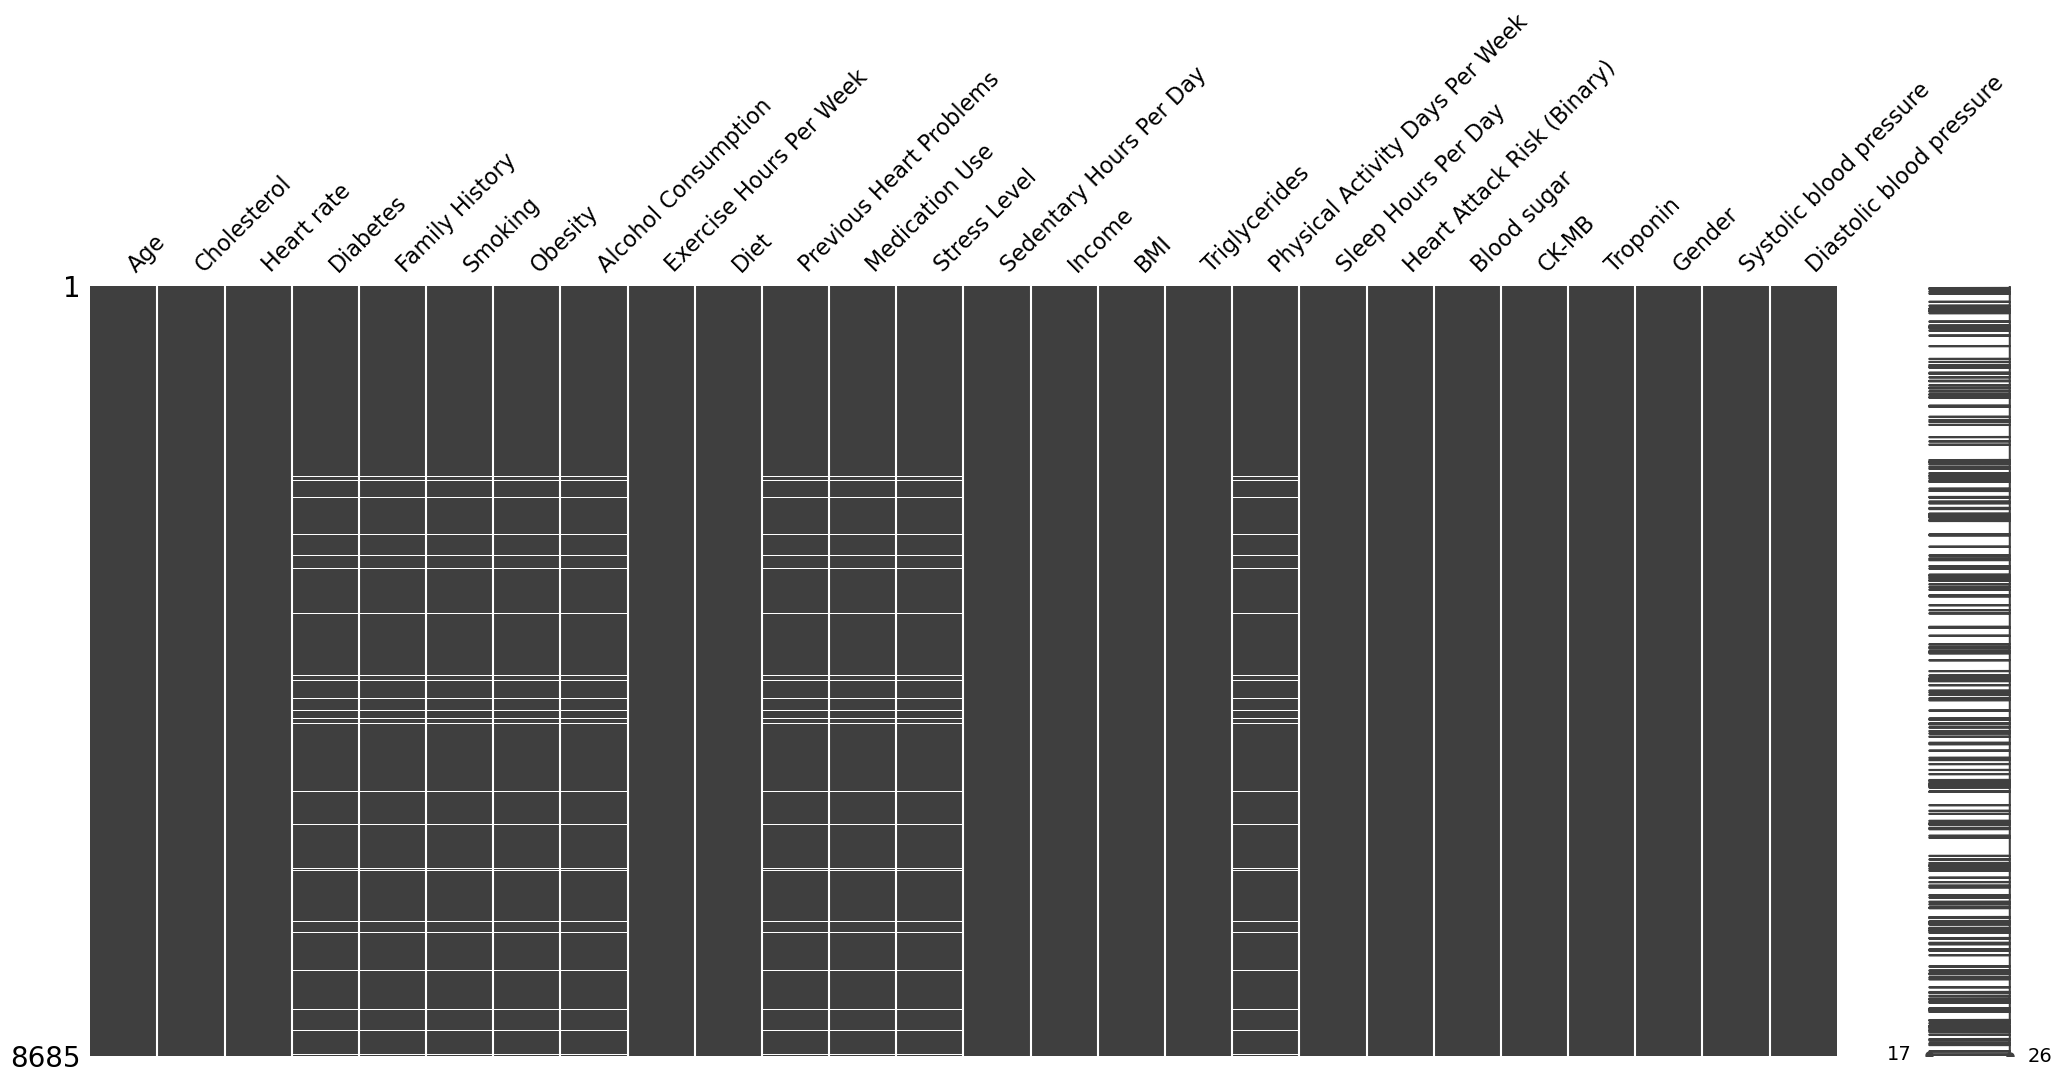

In [15]:
msno.matrix(dfs_dict['heart_train'].sample(len(dfs_dict['heart_train'])));

Можно увидеть, что пропуски имеют равномерный характер: если у одного id есть один пропуск, у него также есть и остальные пропуски (в столбцах `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`, `Previous Heart Problems`)

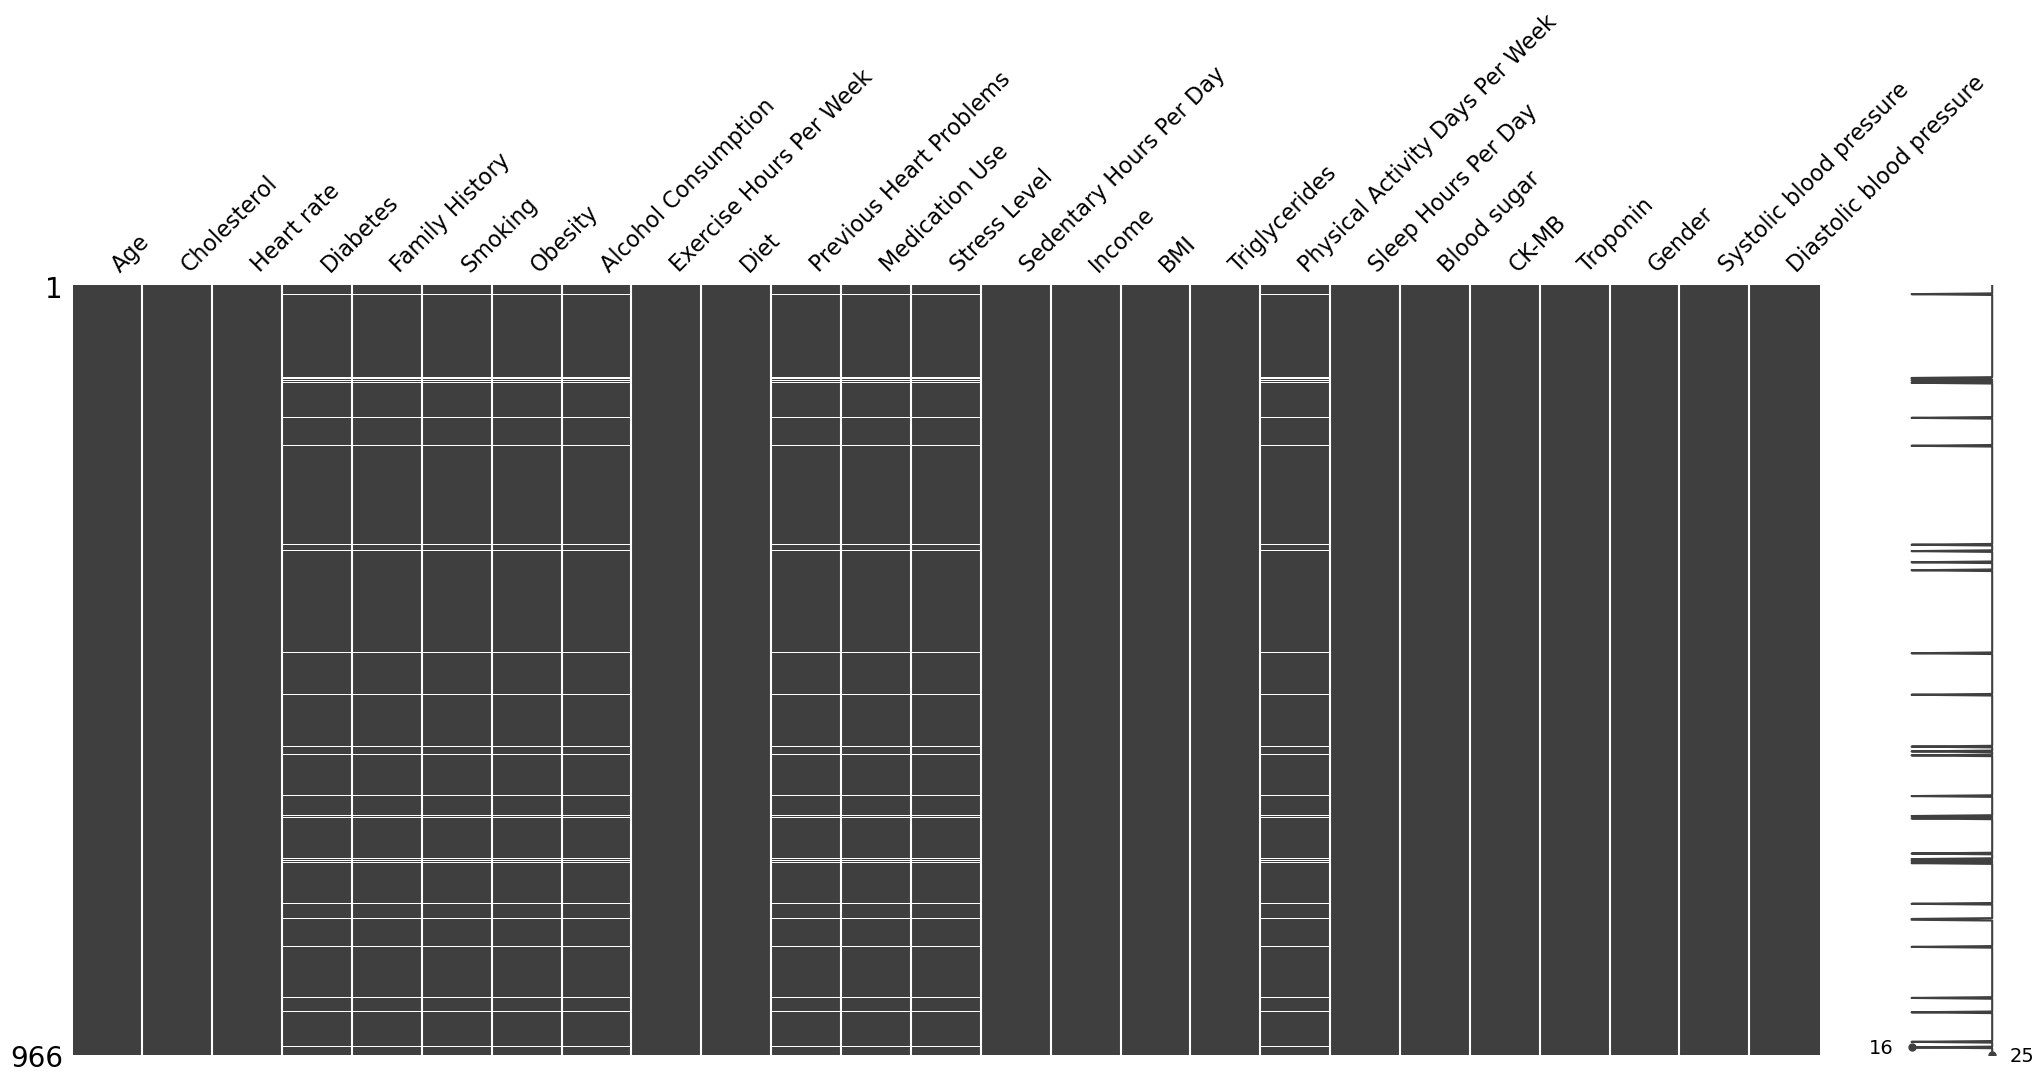

In [16]:
msno.matrix(dfs_dict['heart_test'].sample(len(dfs_dict['heart_test'])));

Ситуация такая же, как и в датафрейме с тренировочной выборкой. Скорее всего, это связано с отсутствием заполнения анкеты данными пациентами. Заполним пропуски на этапе подготовки в пайплайне.

### Шаг 2.2 Приведение названий

Используем созданный трансформер `ColumnNameCleaner`, чтобы привести все названия к единому стилю `snake_case` для удобства работы с признаками.

In [17]:
cleaner = ColumnNameCleaner(return_mapping=True, validate=True)
for name, df in dfs_dict.items():
    cleaned_df = cleaner.fit_transform(df)
    dfs_dict[name] = cleaned_df
    mapping = cleaner.mappings_
    print(f'Датафрейм {name}:')
    display(mapping)

Датафрейм heart_train:


,Старые названия,Новые названия
0,Age,age
1,Cholesterol,cholesterol
2,Heart rate,heart_rate
3,Diabetes,diabetes
4,Family History,family_history
5,Smoking,smoking
6,Obesity,obesity
7,Alcohol Consumption,alcohol_consumption
8,Exercise Hours Per Week,exercise_hours_per_week
9,Diet,diet


Датафрейм heart_test:


,Старые названия,Новые названия
0,Age,age
1,Cholesterol,cholesterol
2,Heart rate,heart_rate
3,Diabetes,diabetes
4,Family History,family_history
5,Smoking,smoking
6,Obesity,obesity
7,Alcohol Consumption,alcohol_consumption
8,Exercise Hours Per Week,exercise_hours_per_week
9,Diet,diet


Названия всех столбцов в обоих датафреймах были приведены к стилю `snake_case`.

### Шаг 2.3 Проверка на наличие явных и неявных дубликатов

Выполним проверку на наличие явных дубликатов в датафреймах.

In [18]:
for name, df in dfs_dict.items():
    check_duplicates(df, name)

В датафрейме из таблицы heart_train.csv нет явных дубликатов.
В датафрейме из таблицы heart_test.csv нет явных дубликатов.


Можно увидеть, что в обоих датафреймах отсутствуют явные дубликаты. Мы уже делали проверку на наличие неявных дубликатов в столбцах `id`, перед тем как сделать его идентификатором таблицы. В остальных столбцах данные могут повторяться, но это не будет являться неявными дубликатами.

Проверим уникальные значения в столбцах, которых указаны бинарные значения, и категориальных столбцах.

In [19]:
check_cols = [
    'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
    'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
    'physical_activity_days_per_week', 'gender'
]

data = {}

for name, df in dfs_dict.items():
    col_data = {}
    for col in check_cols:
        col_data[col] = df[col].sort_values().unique().tolist()
    data[name] = pd.Series(col_data)
        
summary_df = pd.DataFrame(data)

# Делаем мультииндекс: уровень 0 - датафрейм, уровень 1 - уникальные значения
summary_df.columns = pd.MultiIndex.from_product([summary_df.columns, ['unique_values']])

summary_df

,heart_train,heart_test
,unique_values,unique_values
diabetes,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
family_history,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
smoking,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
obesity,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
alcohol_consumption,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
diet,"[0, 1, 2, 3]","[0, 1, 2, 3]"
previous_heart_problems,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
medication_use,"[0.0, 1.0, nan]","[0.0, 1.0, nan]"
stress_level,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ..."


Видим, что в столбце `gender` помимо значений `Male` и `Female` есть значения `1.0` и `0.0`. Стандартной практикой считается кодирование `Male` - 1, `Female` - 0. Закодируем значения `Male` как 1.0, а `Female` как 0.0 в обоих датафреймах.

In [20]:
for name, df in dfs_dict.items():
    df['gender'] = df['gender'].astype(str).map({
        'Male': 1.0,
        'Female': 0.0,
        '1.0': 1.0,
        '0.0': 0.0
    }).astype(float)

    print(f'Датафрейм {name}, уникальные значения в столбце gender:') 
    print(df['gender'].value_counts())

Датафрейм heart_train, уникальные значения в столбце gender:
gender
1.0    6038
0.0    2647
Name: count, dtype: int64
Датафрейм heart_test, уникальные значения в столбце gender:
gender
1.0    672
0.0    294
Name: count, dtype: int64


### Шаг 2.4 Заполнение пропусков. Приведение столбцов к нужным типам.

У нас есть несколько столбцов, в которых находятся бинарные признаки (после заполнения пропусков в них также есть значение `-1`):
- `diabetes`
- `family_history`
- `smoking`
- `obesity`
- `alcohol_consumption`
- `previous_heart_problems`
- `medication_use`

Целевой признак `heart_attack_risk` является бинарным.

Также в столбце `diet` находятся значения от 0 до 3, так же в столбцах `stress_level` и `physical_activity_days_per_week` находятся значения не превышающие 10.

Сейчас эти столбцы имеют тип данных `float64`, однако, учитывая что в них хранятся только маленькие значения, а также то что нас интересует только целая часть, приведём эти столбцы к типу `int8` для экономии памяти.

На данный момент в этих столбцах есть пропуски. В пайплайне будем использовать `SimpleImputer` для их заполнения, поэтому используем его и для датафреймов, которые используются для исследования. Однако сохраним копии датафреймов с пропусками, чтобы в дальнейшем посмотреть, как распределены данные в строках с пропусками и без.

In [21]:
dfs_dict_with_nan = {name: df.copy(deep=True) for name, df in dfs_dict.items()}

Заполним пропуски с помощью `SimpleImputer`. Для числовых признаков используем `strategy='median'`, для бинарных - `strategy='most_frequent'`. 

In [22]:
num_imputer = SimpleImputer(strategy='median')
bin_imputer = SimpleImputer(strategy='most_frequent')

num_cols = ['stress_level', 'physical_activity_days_per_week']
bin_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use']

for name, df in dfs_dict.items():
    if name == 'heart_train':
        df[num_cols] = num_imputer.fit_transform(df[num_cols])
        df[bin_cols] = bin_imputer.fit_transform(df[bin_cols])
    else:
        df[num_cols] = num_imputer.transform(df[num_cols])
        df[bin_cols] = bin_imputer.transform(df[bin_cols])
    print(f'В датафрейме {name} {df.isna().sum().sum()} пропусков.')

В датафрейме heart_train 0 пропусков.
В датафрейме heart_test 0 пропусков.


Пропуски были заполнены. Приведём типы данных в интересующих нас колонках к типу `int8`.

In [23]:
# Добавляем в список название целевого признака
check_cols.append('heart_attack_risk')

for name, df in dfs_dict.items():
    for col in check_cols:
        if col in df.columns:
            df[col] = df[col].astype('int8')

dfs_dict['heart_train'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8685 non-null   int8   
 4   family_history                   8685 non-null   int8   
 5   smoking                          8685 non-null   int8   
 6   obesity                          8685 non-null   int8   
 7   alcohol_consumption              8685 non-null   int8   
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int8   
 10  previous_heart_problems          8685 non-null   int8   
 11  medication_use                   8685 non-null   int8   
 12  stress_level          

Типы данных в столбцах были приведены к `int8` для оптимизации использования памяти, так как все значения в этих столбцах были целочисленными, а также имели небольшие значения.

## Шаг 3. Исследовательский анализ данных

### Шаг 3.1 Основные статистики

Выведем на экран основные статистики.

**Датафрейм heart_train**

In [24]:
dfs_dict['heart_train'].describe().drop(check_cols, axis=1)

,age,cholesterol,heart_rate,exercise_hours_per_week,sedentary_hours_per_day,income,bmi,triglycerides,sleep_hours_per_day,blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.503378,0.499164,0.496055,0.496774,0.505484,0.503737,0.227339,0.048159,0.036689,0.450295,0.497634
std,0.231174,0.284716,0.023453,0.284810,0.285340,0.284698,0.282561,0.286320,0.328061,0.076635,0.075531,0.060157,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258427,0.267857,0.034830,0.263286,0.255875,0.251922,0.254190,0.263636,0.166667,0.227018,0.048229,0.036512,0.303226,0.348837
50%,0.460674,0.499780,0.050412,0.502110,0.499920,0.494889,0.494774,0.503603,0.500000,0.227018,0.048229,0.036512,0.445161,0.500000
75%,0.640449,0.746429,0.065995,0.748709,0.744623,0.741036,0.736974,0.750649,0.833333,0.227018,0.048229,0.036512,0.600000,0.651163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Видим, что все количественные признаки нормализованы, так что если и есть какие-то аномальные значения, мы не сможем этого понять.

**Датафрейм heart_test**

In [25]:
check_cols.remove('heart_attack_risk')
dfs_dict['heart_test'].describe().drop(check_cols, axis=1)

,age,cholesterol,heart_rate,exercise_hours_per_week,sedentary_hours_per_day,income,bmi,triglycerides,sleep_hours_per_day,blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.490706,0.506715,0.484408,0.476796,0.486688,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822
std,0.231068,0.282039,0.035502,0.284902,0.287826,0.273879,0.291987,0.284534,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935
min,0.044944,0.000000,0.000000,0.000336,0.001187,0.003351,0.002598,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279
25%,0.247191,0.243750,0.036664,0.243431,0.258713,0.261446,0.217527,0.249675,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837
50%,0.460674,0.499780,0.050412,0.502110,0.501327,0.492015,0.471185,0.488961,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372
75%,0.640449,0.710714,0.065995,0.734425,0.759591,0.705371,0.720503,0.718182,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535
max,0.853933,0.996429,1.000000,0.998938,0.999033,0.998885,0.999496,0.998701,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698


Видим, что ситуация аналогична тренировочной выборке.

### Шаг 3.2 Построение графиков

Для начала посмотрим на соотношение классов целевого признака.

In [26]:
dfs_dict['heart_train']['heart_attack_risk'].value_counts()

heart_attack_risk
0    5672
1    3013
Name: count, dtype: int64

Видим, что у целевого признака есть дисбаланс классов. Построим графики для признаков, используя наш таргет в качестве `hue`, а также параметр `common_norm=False` чтобы учесть имеющийся дисбаланс классов.

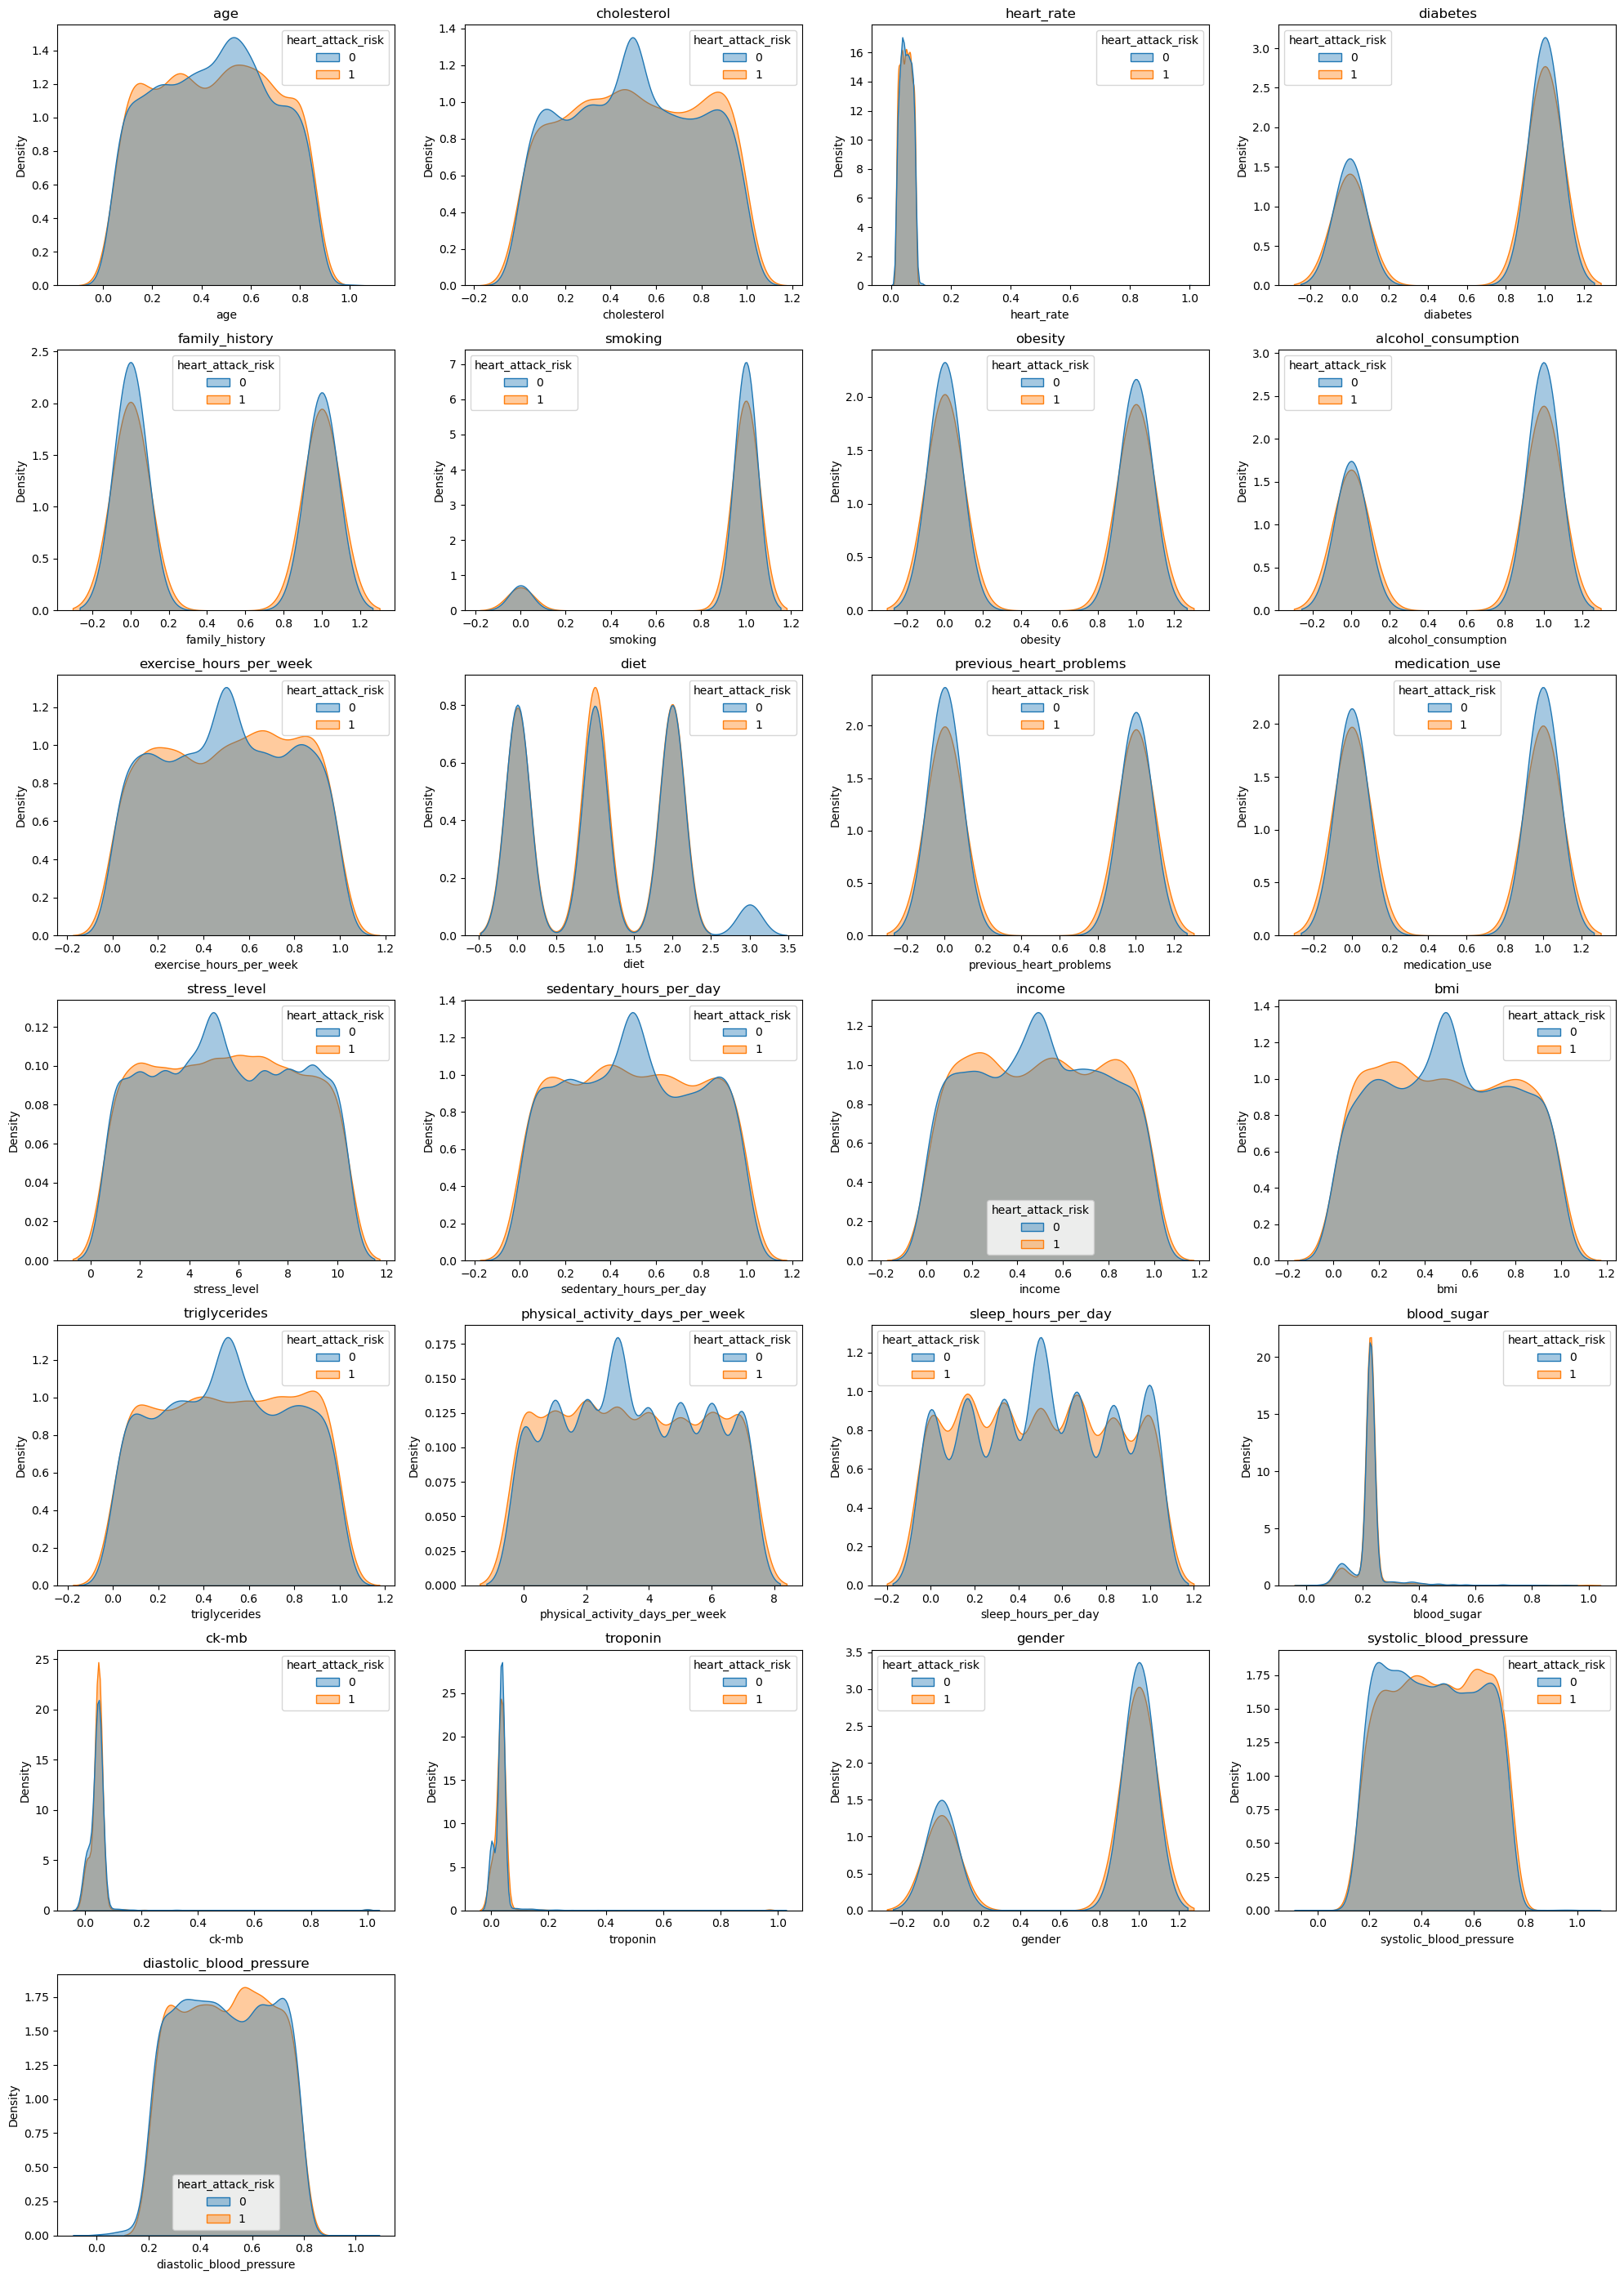

In [27]:
# числовые признаки
num_cols = dfs_dict['heart_train'].select_dtypes(include='number').columns.tolist()
num_cols.remove('heart_attack_risk')  # таргет отдельно

# сетка графиков
n_cols = 4
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        data=dfs_dict['heart_train'],
        x=col,
        hue='heart_attack_risk',
        ax=ax,
        fill=True,
        alpha=0.4,
        common_norm=False
    )
    ax.set_title(col)
    
# Убираем пустые подграфики
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Можно увидеть, что признаки практически одинаковые у обоих классов нашего таргета. 

Из интересного можно отметить наличие категории "3" у признака `diet` только у класса 0. Количество таких строк довольно мало, однако у всех пациентов с такой диетой отсутствуют риск сердечного приступа.

### Шаг 3.2 Матрицы корреляций

Построим матрицы корреляций Phik для наших выборок.

**Тренировочная выборка**

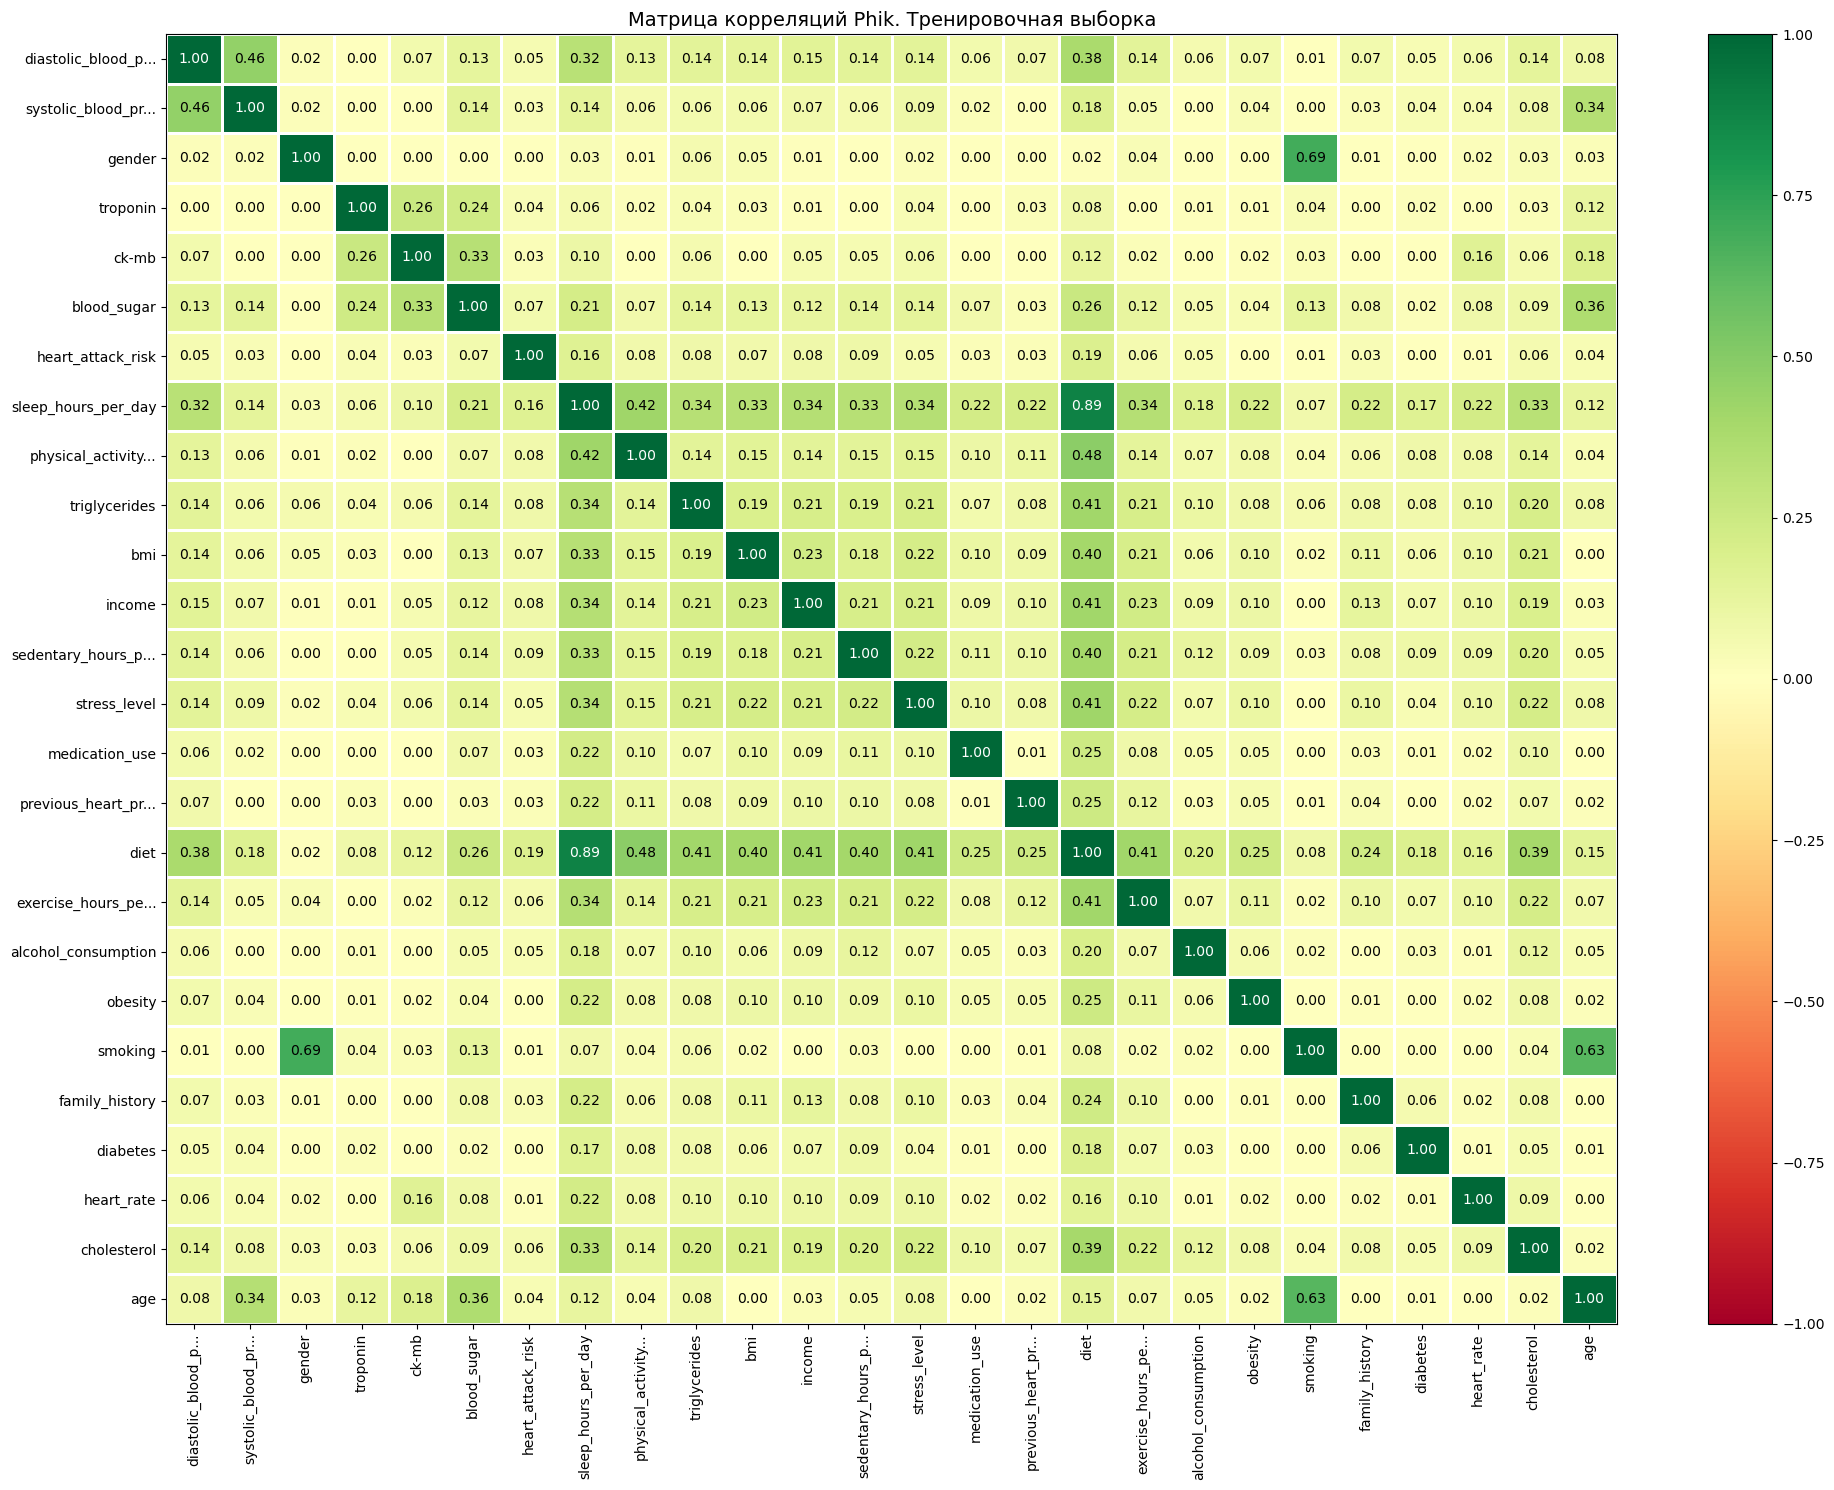

In [28]:
# Отмечаем количественные столбцы
interval_cols = ['diastolic_blood_pressure', 'systolic_blood_pressure', 'troponin', 'ck-mb', 'blood_sugar', 'sleep_hours_per_day', 'physical_activity_days_per_week',
                 'triglycerides', 'bmi', 'income', 'sedentary_hours_per_day', 'stress_level', 'exercise_hours_per_week', 'heart_rate', 'cholesterol', 'age'
                 ]

# Создаём phik матрицу для тренировочной выборки
phik_train = phik_matrix(dfs_dict['heart_train'], interval_cols=interval_cols)

# Строим график матрицы корреляций phik
plot_correlation_matrix(
    phik_train.values,
    x_labels=phik_train.columns,
    y_labels=phik_train.index,
    figsize=(20, 15),
    title='Матрица корреляций Phik. Тренировочная выборка'
)

Видим, что у целевого признака очень слабые корреляции с всеми признаками.

Можно отметить сильную корреляцию между признаками `diet` и `sleep_hours_per_day` (0.89). Относительно высокая корреляция есть у признака `smoking` с признаками `age` (0.63) и `gender` (0.69).

Построим матрицу корреляций `Phik` для тестовой выборки.

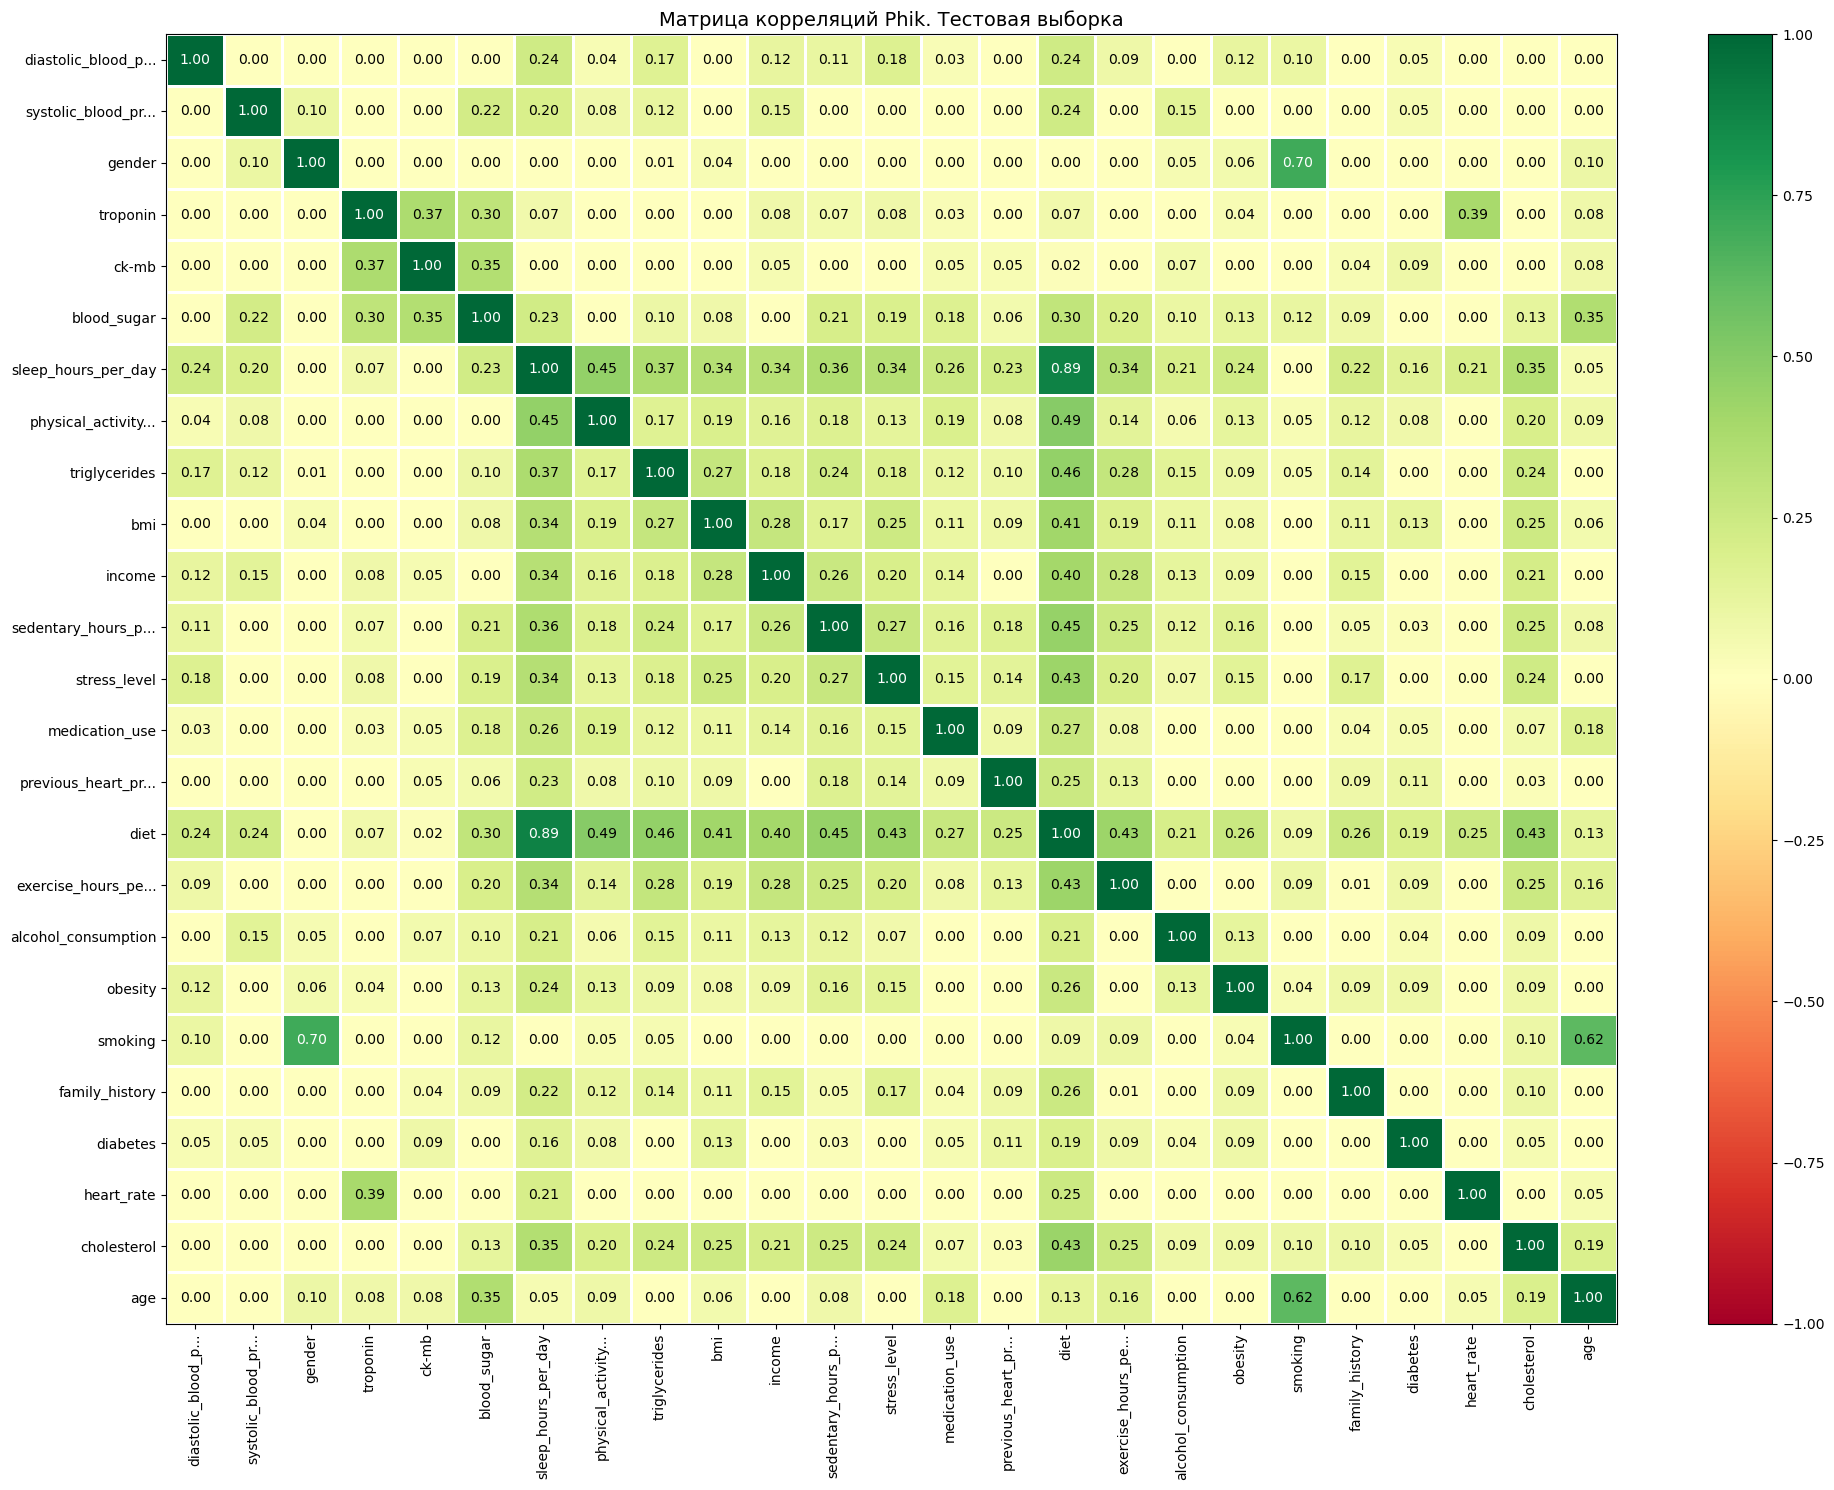

In [29]:
# Создаём phik матрицу для тренировочной выборки
phik_test = phik_matrix(dfs_dict['heart_test'], interval_cols=interval_cols)

# Строим график матрицы корреляций phik
plot_correlation_matrix(
    phik_test.values,
    x_labels=phik_test.columns,
    y_labels=phik_test.index,
    figsize=(20, 15),
    title='Матрица корреляций Phik. Тестовая выборка'
)

Видим аналогичную ситуацию.

Построим матрицу корреляций `Phik` для датафрейма без пропусков.

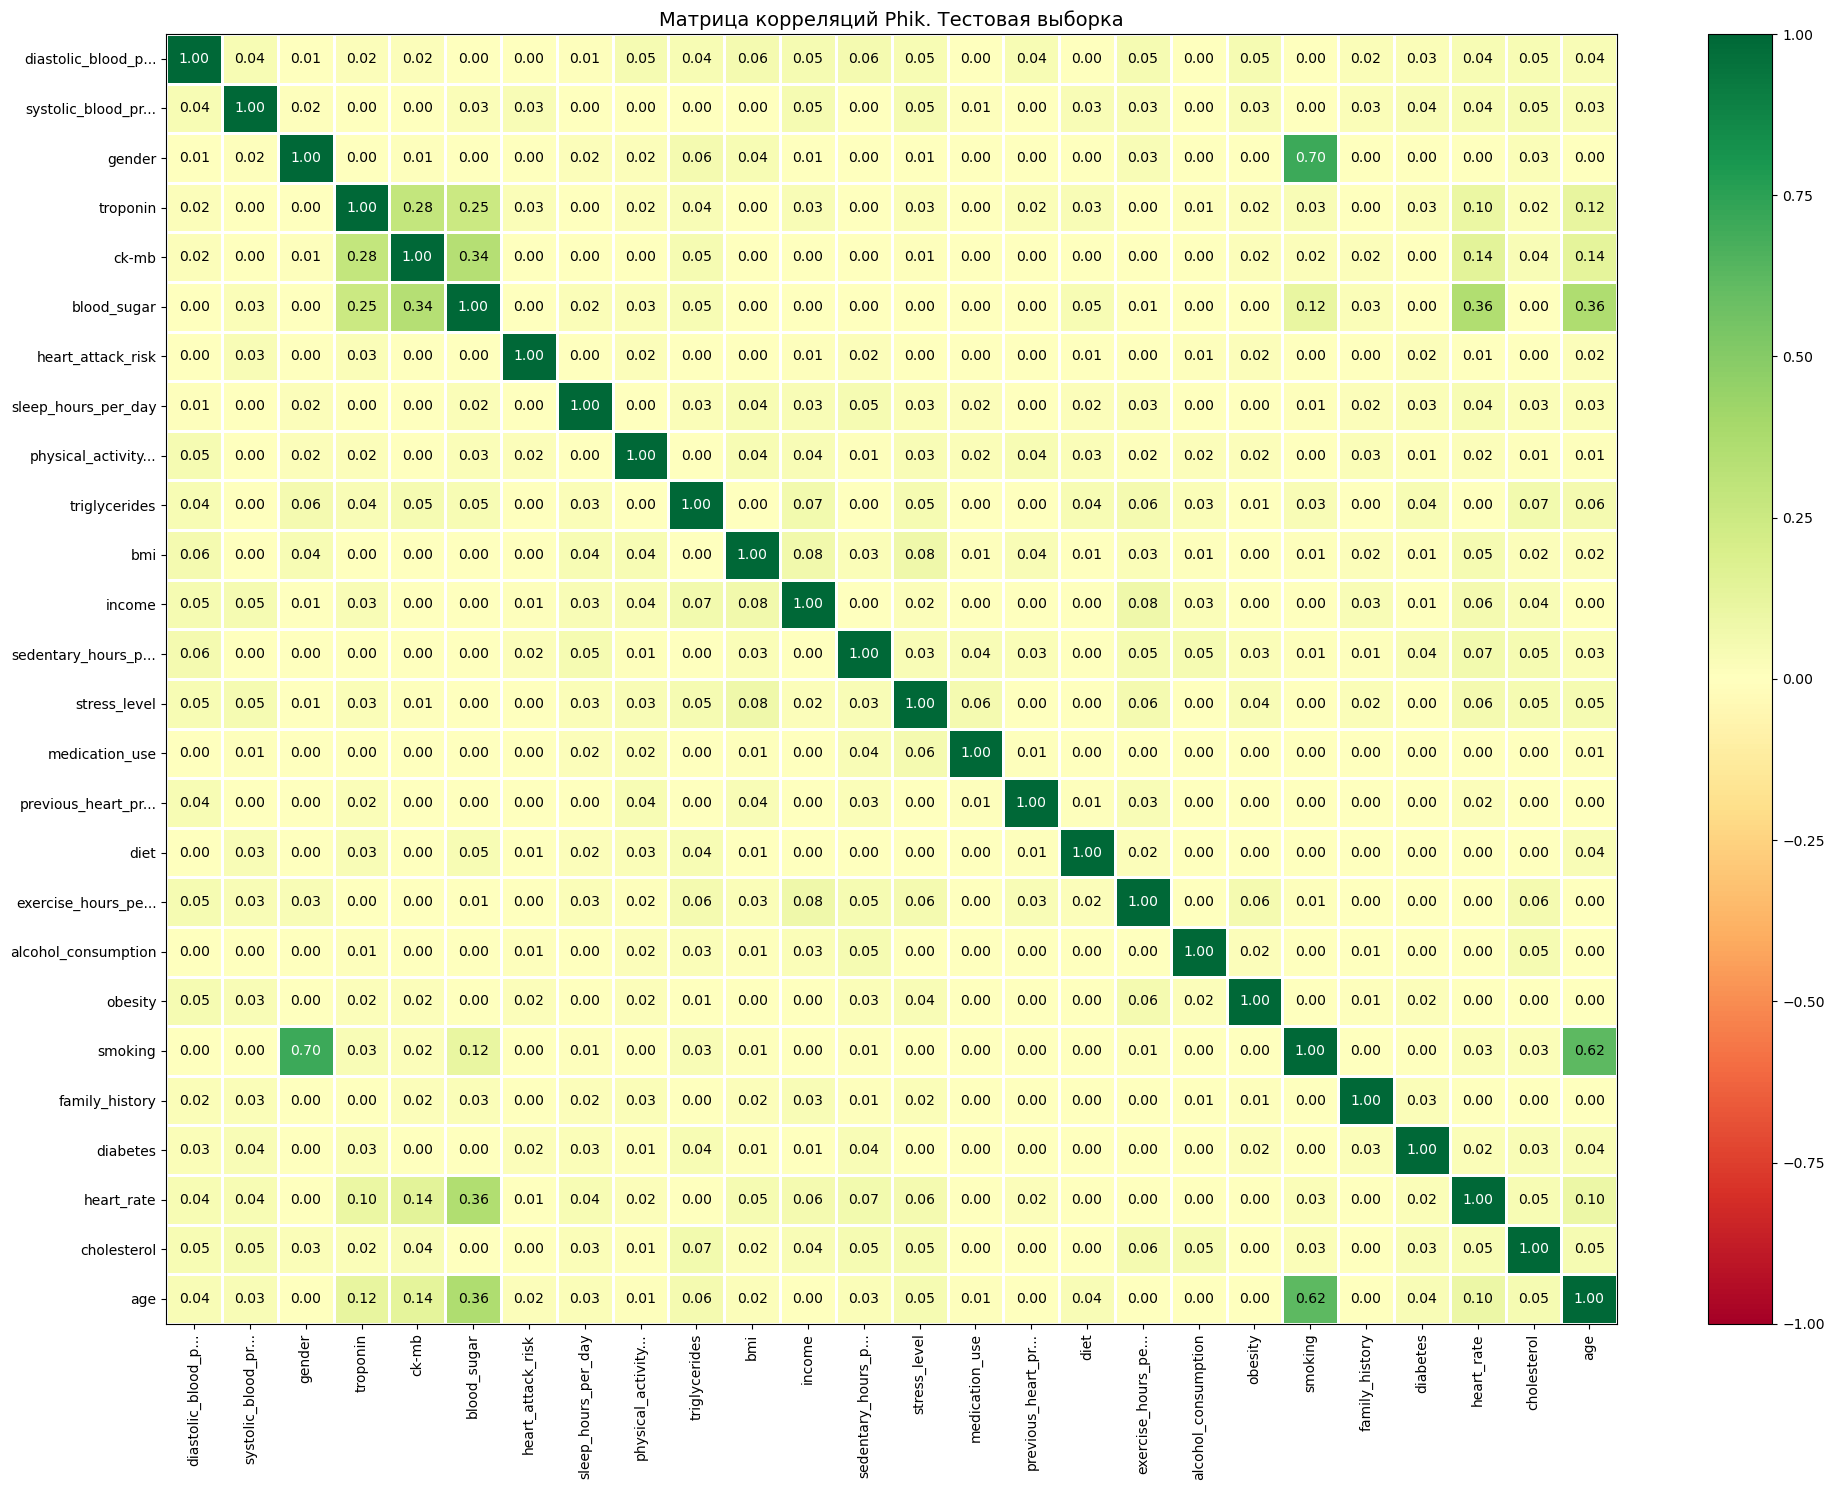

In [30]:
# Создаём phik матрицу для тренировочной выборки
phik_train_with_nan = phik_matrix(dfs_dict_with_nan['heart_train'].dropna(), interval_cols=interval_cols)

# Строим график матрицы корреляций phik
plot_correlation_matrix(
    phik_train_with_nan.values,
    x_labels=phik_train.columns,
    y_labels=phik_train.index,
    figsize=(20, 15),
    title='Матрица корреляций Phik. Тестовая выборка'
)

Можно увидеть, что удаление пропусков убирает многие корреляции у признаков. Получается, что строки с пропусками несут в себе какую-то важную информацию для признаков. Ситуация по пропускам в тренировочной и тестовой выборках одинаковая, мы не можем удалять строки с пропусками из тестовой выборки, поэтому можно считать, что решение заполнить пропуски было правильным.

## Шаг 4. Подготовка данных к обучению

### Шаг 4.1 Разбивка данных на тренировочную и тестовую выборки

Содержание тропонина (`Troponin`) и креатинкиназы-МВ (`CK-MB`) в крови повышается при повреждении миокарда, особенно при остром инфартке, так что в этих признаках может быть косвенная утечка целевого признака, поэтому не будем использовать их при обучении модели. Также не будем использовать признак дохода (`Income`), так как если он и может оказывать какое-то влияние, оно не является прямым.

In [31]:
# Отмечаем признаки, которые не будут использоваться при обучении
cols_to_drop = ['Troponin', 'CK-MB', 'Income']

# Разбиваем данные на тренировочную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(
    heart_train_df.drop(['Heart Attack Risk (Binary)'] + cols_to_drop, axis=1),
    heart_train_df['Heart Attack Risk (Binary)'],
    random_state = RANDOM_STATE,
    stratify = heart_train_df['Heart Attack Risk (Binary)']
)

### Шаг 4.2 Создание пайплайна

Создадим пайплайн для обработки данных, в котором будем использовать написанные трансформеры:
- `ColumnNameCleaner` — приводит названия в столбцах к стилю `snake-case`
- `SimpleImputerStep` — заполняет пропуски в количественных столбцах медианным значением, а в бинарных столбцах модой.
- `GenderCleaner` — оставляет только два класса в столбце `Gender` (1 - мужчина, 0 - женщина)
- `TypeConverter` — приводит тип столбцов, в которых есть только бинарные значения, а также малые целочисленные значения (1-10), к типу `int8` ради экономии памяти.

Помним, что у нас присутствует дисбаланс классов (Класс 0 (нет риска) - 5672 пациентов, класс 1 (есть риск) - 3013 пациентов). Пациентов класса 1 примерно в 1.85 меньше, при этом нам важнее правильно предсказать их. Поэтому будем использовать метод `class_weights` модели `CatBoost`.

In [32]:
num_cols = ['stress_level', 'physical_activity_days_per_week']
bin_cols = ['diabetes', 'smoking', 'family_history', 'obesity', 'alcohol_consumption', 
            'previous_heart_problems', 'medication_use']
cat_cols = bin_cols + ['gender']

preprocessor = Pipeline([
    ('name_cleaner', ColumnNameCleaner(validate=False)),
    ('num_imputer', SimpleImputerStep(columns=num_cols, strategy='median')),
    ('bin_imputer', SimpleImputerStep(columns=bin_cols, strategy='most_frequent')),
    ('gender_cleaner', GenderCleaner(column='gender')),
    ('type_converter', TypeConverter(columns=num_cols + bin_cols + ['gender']))
])

pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        eval_metric='AUC',
        cat_features=cat_cols,
        auto_class_weights='Balanced',
        verbose=0,
        random_state=RANDOM_STATE))
])

## Шаг 5. Обучение модели

### Шаг 5.1 Поиск лучшей модели с помощью RandomizedSearchCV

Для поиска лучшей модели будем использовать `RandomizedSearchCV`, так как `CatBoost` сам по себе довольно медленно обучается, так что если мы будем перебирать большое количество гиперпараметров и использовать `GridSearchCV`, это займёт много времени.

In [33]:
# словарь гиперпараметров
param_grid = {
    'model__depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 2, 3, 4, 5, 7, 10],
    'model__iterations': [200, 500, 1000],
    'model__border_count': [32, 64, 128], 
    'model__subsample': [0.6, 0.8, 1.0],
    'model__rsm': [0.8, 1.0],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring,
    refit='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE,
    return_train_score=False
)

search.fit(X_train, y_train)

print("Лучшая модель:", search.best_estimator_)
print("Лучшие параметры:", search.best_params_)
print("Лучшее значение метрики при кросс-валидации:", search.best_score_)

Лучшая модель: Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('name_cleaner', ColumnNameCleaner()),
                                 ('num_imputer',
                                  SimpleImputerStep(columns=['stress_level',
                                                             'physical_activity_days_per_week'])),
                                 ('bin_imputer',
                                  SimpleImputerStep(columns=['diabetes',
                                                             'smoking',
                                                             'family_history',
                                                             'obesity',
                                                             'alcohol_consumption',
                                                             'previous_heart_problems',
                                                             'medication_use'],
                                                    strate

In [34]:
# Создаём датафрейм с результатами работы GridSearchCV
results = pd.DataFrame(search.cv_results_)

print('Метрики лучшей модели:')
for score in scoring.keys():
    print(f'{score}:', end='')
    print(round(results.iloc[search.best_index_, :][f'mean_test_{score}'], 3))

Метрики лучшей модели:
recall:0.243
precision:0.477
f1:0.322
roc_auc:0.604


Можно увидеть, что метрики recall, precision, в следствии этого, f1, довольно низкие. ROC-AUC = 0.604, то есть модель немногим лучше простого угадывания.

Достанем из `RandomizedSearchCV` лучший пайплайн, модель и препроцессор.

In [35]:
# Получаем лучший пайплайн
best_pipe = search.best_estimator_
# Достаём из пайплайна модель
best_model = best_pipe.named_steps['model']
# # Достаём препроцессор
preprocessor = best_pipe.named_steps['preprocessor']

### Шаг 5.2 Анализ важности признаков Shap

Построим график `beeswarm`, чтобы оценить важность признаков.

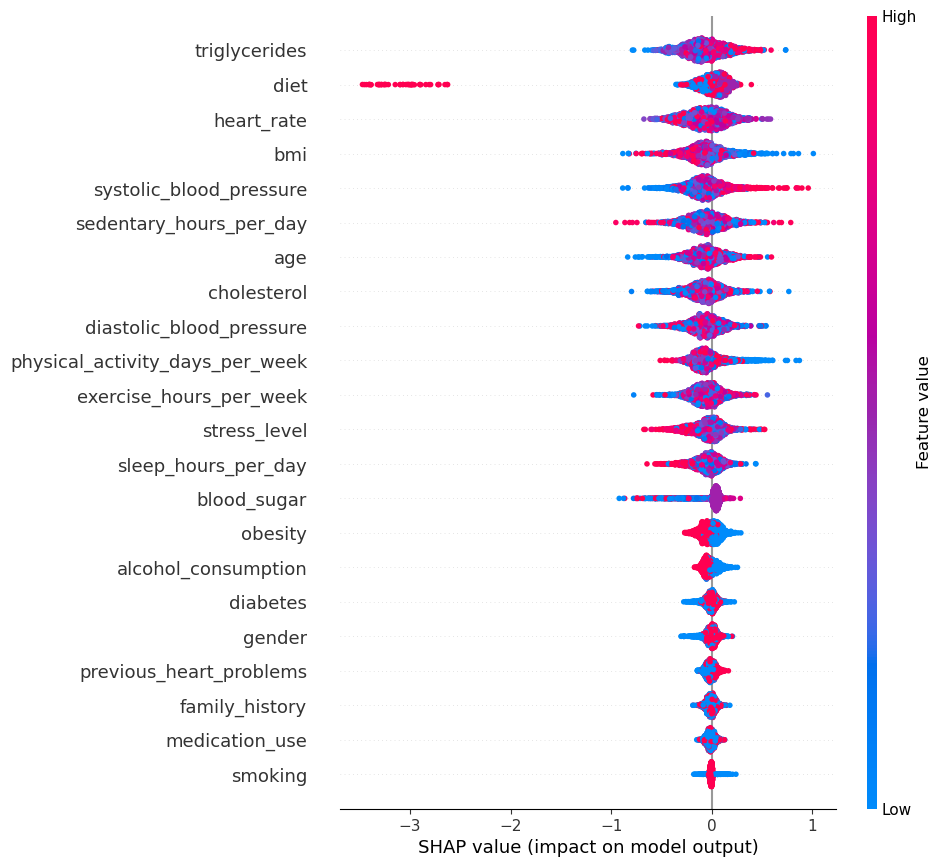

In [36]:
# Преобразовываем X_val для shap
X_val_transformed = preprocessor.transform(X_val)

# Инициализируем JS-компонент визуализаций shap
shap.initjs()

# Создаём TreeExplainer
explainer = shap.TreeExplainer(
    model=best_model)
# Считаем shap-значения на тестовой выборке
shap_values = explainer(X_val_transformed)

# Строим график beeswarm для рассчитанных shap-значений
shap.plots.beeswarm(shap_values, max_display=30)

Анализ важности `Shap` значений признаков показывает, что модели тяжело различить классы. У большинства признаков высокие и низкие значения могут повлиять как на предсказание класса 1, так и на предсказание класса 0. Мы видели, что с целевым признаком практически не коррелирует ни один из признаков, а также то, что распределение входных признаков по классам целевого практически одинаково, так что такое поведение ожидаемо.

### Шаг 5.3 Выбор лучшего порога.

В вопросе предсказания риска сердечного приступа нам нужно минимизировать ошибки 2-го рода (False Negative). Для этого нам нужно максимизировать метрику Recall.

Построим precision/recall кривую.

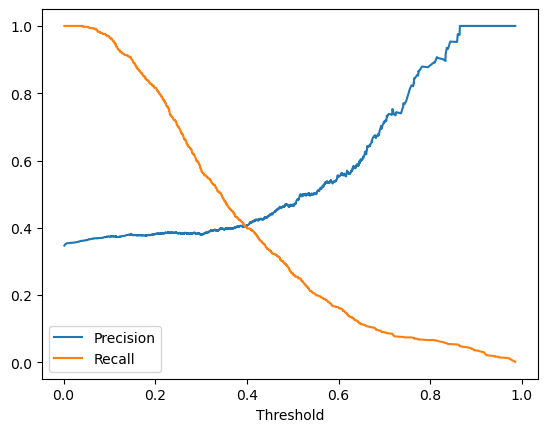

In [37]:
y_val_proba = best_pipe.predict_proba(X_val_transformed)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.show()

Можно увидеть, что при низком пороге `recall` высокий, но низкий `precision`, при высоком — наоборот.

Найдём threshold, при котором метрика `recall` будет равным 1, при этом метрика `f1` будет максимальной.

In [38]:
thresholds = np.linspace(0, 1, 101)

best_threshold = 0.5
best_f1_so_far = 0
desired_recall = 1
results = []

for threshold in thresholds:
    y_pred_t = (y_val_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_t, labels=[0,1]).ravel()
    
    precision = precision_score(y_val, y_pred_t, zero_division=0)
    recall = recall_score(y_val, y_pred_t, zero_division=0)
    f1 = f1_score(y_val, y_pred_t, zero_division=0)
    f2 = fbeta_score(y_val, y_pred_t, beta=2, zero_division=0)
    
    results.append({
        'threshold': round(threshold, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'f1': round(f1, 3),
        'f2': round(f2, 3),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    })
    
    # выбираем порог с recall >= desired_recall и максимальной f1
    if recall >= desired_recall and f1 > best_f1_so_far:
        best_f1_so_far = f1
        best_threshold = threshold

thresholds_df = pd.DataFrame(results)
best_row = thresholds_df.loc[thresholds_df['threshold'] == round(best_threshold, 3)]

print(f'Лучший порог = {best_threshold:.3f}')
print(best_row)

Лучший порог = 0.040
   threshold  precision  recall     f1     f2   tp  tn    fp  fn
4       0.04      0.361     1.0  0.531  0.739  754  86  1332   0


Лучший порог равен 0.04 - у модели не получается разделять классы. Построим матрицу ошибок.

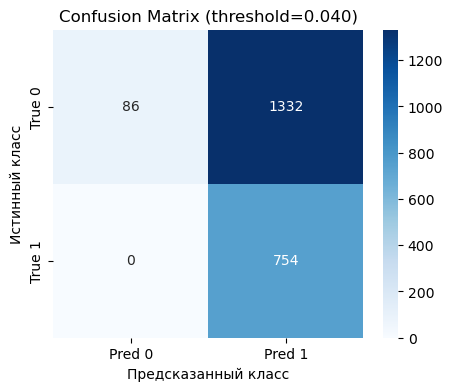

In [39]:
# Матрица ошибок для лучшего порога
best_pred = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, best_pred, labels=[0,1])

# Визуализация
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Confusion Matrix (threshold={best_threshold:.3f})')
plt.show()

Видим, что правильно предсказанных пациентов без риска сердечного приступа всего 86, когда неправильно предсказанных — 1332. Тем не менее, мы не пропускаем ни одного пациента, у которого действительно есть риск сердечного приступа. Получается, это тот компромисс, на который мы должны пойти, учитывая то, какие данные были переданы.

### Шаг 5.4 Выполнение предсказаний на тестовой выборке и сохранение результатов в CSV-файл

Получим вероятности предсказаний на тестовой выборки, которые приведём к классам 1/0, используя найденный лучший порог.

In [40]:
# Получаем вероятности
probabilities = \
    best_pipe.predict_proba(preprocessor.transform(heart_test_df.drop(cols_to_drop, axis=1)))[:, 1]
# Получаем классы по вероятностям
predictions = (probabilities >= best_threshold).astype(float)

pred_1_cnt = (predictions == 1.0).sum()
pred_0_cnt = (predictions == 0.0).sum()
print(f'Количество предсказаний класса "0": {pred_0_cnt}')
print(f'Количество предсказаний класса "1": {pred_1_cnt}')

Количество предсказаний класса "0": 48
Количество предсказаний класса "1": 918


Можно заметить, что предсказаний класса 0 крайне мало (35 против 931). К сожалению, с этим мало что можно сделать: данные слишком шумные и почти не связаны с целевым признаком. Поэтому оптимальным решением было сфокусироваться на том, чтобы не пропустить ни одного пациента с риском сердечного приступа.

Сохраним предсказания в CSV-файл.

In [41]:
# Составляем датафрейм id:предсказание
predictions_df = pd.DataFrame({
    'id': heart_test_df.index,
    'prediction': predictions
})

# Путь к папке дата относительно корня
data_dir = Path('../data')

# Сохраняем датафрейм в csv файл
predictions_df.to_csv(data_dir / 'heart_predictions.csv', index=False)

### Шаг 5.5 Сохранение модели

Для начала, сохраним исходный порядок признаков с индексами, чтобы результат был воспроизводимым в приложении `FastAPI` при передаче одной строки.

In [42]:
# Создаём словарь индекс: признак
original_feature_map = {
    i: col for i, col in enumerate(heart_test_df.columns) if col not in cols_to_drop
}

# Добавляем атрибут с получившимся словарем в пайплайн
best_pipe.feature_map = original_feature_map
# Сохраняем названия всех столбцов в стиле snake_case в пайплайн
best_pipe.snake_cols = dfs_dict['heart_test'].columns
# Сохраняем лучший threshold
best_pipe.best_threshold = best_threshold

Для сохранения лучшего пайплайна используем библиотеку `dill`, так как были использованы кастомные трансформеры, и лучшей пайплайн был обучен в интерактивной среде тетрадки Jupyter. Использование `dill` позволит беспроблемно использовать кастомные трансформеры, не вынося их в отдельный файл и не переобучивая пайплайн заново.

In [43]:
app_dir = Path('../FastAPI_app')

with open(app_dir / 'best_pipe.pkl', 'wb') as f:
    dill.dump(best_pipe, f)

## Шаг 6. Общий вывод

1. **Загрузка и обзор данных:**
    Данные из двух csv-файлов были загружены в датафреймы:
    - `heart_train.csv` в датафрейм `heart_train_df` (при исследовании в словарь dfs_dict['heart_train'])
    - `heart_test.csv`в датафрейм `heart_test_df` (при исследовании в словарь dfs_dict['heart_test'])

    После вывода первичной информации было отмечено наличие пропусков во обоих датафреймах, все пропуски находятся в одинаковых столбцах, и если пропуск есть в одном столбце, значит пропуски будут и во всех остальных столбцах. Скорее всего это связано с тем, что некоторые пациенты не заполняли анкеты.

    Были созданы копии датафреймов для использования их в обучении моделей.

2. **Предобработка данных**
    1. Столбец `id` был сделан индексом в обоих датафреймах.
    2. Названия были приведены к стилю `snake_case`
    3. Была выполнена проверка на явные и неявные дубликаты. Явные дубликаты отсутствуют во всех датафреймах. 
    4. Было выявлено, что в столбце `gender` в обоих датафреймах помимо значений 'Male', 'Female' есть значения '1.0', '0.0'. Значения в этом столбце в обоих датафреймах были приведены к 1 (Мужчина) и 0 (Женщина), так как это стандартная практика.
    5. Пропуски были заполнены с использованием `SimpleImputer`: в случае бинарных столбцов использовалась `strategy: most_frequent`, в случае с количественными столбцами - `strategy: median`
    6. Типы данных в бинарных столбцах, а также в столбцах с малыми целочисленными значениями были приведены к типу `int8`

    Все эти действия выполнялись на датафреймах, которые использовались в исследовании. Аналогичные действия были применены к датафреймам, которые использовались для обучения модели, однако они были оформлены как кастомные трансформеры и использовались в пайплайне. Это было сделано для того, чтобы результат работы пайплайна и модели был воспроизводимым в приложении написанном на `FastAPI`.

3. **Исследовательский анализ данных:**
    1. Были выведены все статистики обоих датафреймов. Было отмечено, что большинство признаков нормализованны.
    2. Построены графики `kde` для всех признаков с учётом дисбаланса целевого класса, было отмечено, что все признаки практически не различаются по целевому признаку.
    3. Были построены матрицы корреляций `Phik` для тренировочной и тестовой выборок. Было отмечено, что при удалении пропусков практически все корреляции становятся равными нулю, исходя из этого факта было принято решение заполнить пропуски.

4. **Подготовка данных к обучению модели**
    1. При поиске дополнительной информации было выявлено, что признаки тропонин (`tropoonin`) и креатинкиназа-МВ (`ck-mb`) увеличиваются после инфаркта, поэтому было принято решение не использовать их в обучении модели, так как они могут быть причиной утечки целевого признака. Также было принято решение не использовать признак `income`, так как, если он и может оказывать влияние на риск сердечного приступа, это влияние скорее всего будет являться косвенным.
    2. Были написаны собственные трансформеры для обработки данных:
        - `ColumnNameCleaner` — приводит названия в столбцах к стилю `snake-case`
        - `SimpleImputerStep` — заполняет пропуски в количественных столбцах медианным значением, а в бинарных столбцах модой.
        - `GenderCleaner` — оставляет только два класса в столбце `Gender` (1 - мужчина, 0 - женщина)
        - `TypeConverter` — приводит тип столбцов, в которых есть только бинарные значения, а также малые целочисленные значения (1-10), к типу `int8` ради экономии памяти. Этот подход хорош тем, что при передаче данных в приложении `FastAPI`, данные нужно будет обрабатывать минимальным образом, основные действия будут автоматически выполняться при предсказании.
    3. Был создан пайплайн, где были применены написанные трансформеры.

5. **Обучение модели**
    1. В качестве модели для решения задачи был выбран `CatBoost`. Лучшая модель была найдена с использованием `RandomizedSearchCv`. Исследовательский анализ данных показал, что между входными и целевым признаком нет связи.
    2. Так как главной задачей было минимизировать ошибки False Negative, был найден и сохранён как параметр пайплайна лучший `threshold`, при котором `recall` = 1, а метрика `f1` имеет наилучший показатель.
    3. Было выполнено предсказание на датасете с тестовой выборкой. Предсказания были сохранены в файл `csv` в формате `id: prediction`.
    4. Лучший пайплайн был сохранён в файл `best_pipe.pkl` с помощью `dill`, так как были использованы собственные трансформеры. При использовании `joblib` в приложении `FastAPI` возникала ошибка, что при предсказании пайплайн не мог найти кастомные трансформеры, так как искал их в __main__, поскольку среда тетрадки и является __main__. Чтобы использовать пайплайн, сохранённый с помощью `joblib` пришлось бы выносить трансформеры в отдельный файл, при этом пришлось бы заново выполнять все действия с пайплайном, которые уже выполнены в этой тетрадке. Поэтому было принято решение использовать `dill`, который умеет сериализировать функции и классы прямо из интерактивного сеанса.

6. **Рекомендации заказчику:**
    1. **Предоставление исходных данных:** Передавать данные в исходном виде, а не после нормализации. Это позволит выявлять аномальные значения, выбросы и ошибки измерений. Как вариант - можно прилагать максимальные/минимальные значения для каждого признака, чтобы была возможность восстановить их реальные значения.
    2. **Обработка пропусков:** Так как строки с пропусками имеют отличающееся распределение признаков, необходимо определить причину их появления, а также разработать стратегию их обработки: удаление или заполнение определённым методом.
    3. **Расширение набора признаков:** Поскольку было установлено, что у имеющегося набора входных признаков отсутствует связь с целевым, стоит рассмотреть возможность добавления новых данных — например, дополнительные клинические анализы, результаты ЭКГ.